# CONSEGNA
Questo homework ha l’obiettivo di affrontare un problema di classificazione, cercando di ottenere le migliori prestazioni possibili, utilizzando i modelli e le metodologie viste a lezione. Il dataset da utilizzare è CIFAR10: contiene 60,000 immagini (50,000 di training e 10,000 di test) divise in 10 classi, a risoluzione 32x32 pixel, a colori. Questa è la pagina di riferimento del dataset.

Nello specifico, i requisiti dell’homework sono:

caricare correttamente il dataset CIFAR10;
utilizzare i seguenti modelli di classificazione: regressione logistica, k-NN, SVM, decision tree;
effettuare opportunamente la model selection;
riportare le prestazioni ottenuti, secondo le metriche di valutazione appropriate.
La strategia di esecuzione di ciascuna di queste fasi è a scelta dello studente. La valutazione dell’homework terrà conto della correttezza metodologica, della correttezza dell’implementazione e della completezza dell’approccio di ricerca del modello migliore.

Nel caso in cui l’allenamento dei modelli risulti eccessivamente dispensioso in termini di tempo, è possibile valutare l’ipotesi di sotto-campionamento del dataset.

In [1]:
#importo librerie

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

In [3]:
#funzione per caricare i dati
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
    return data, labels

X_train_batches = []
y_train_batches = []

#carico le diverse batches
for i in range (1, 6):
    X_temp, y_temp = unpickle(f"/kaggle/input/cifar10-files/cifar-10-batches-py/data_batch_{i}")
    X_train_batches.append(X_temp)
    y_train_batches.extend(y_temp)

#carico i dati di test e trasformo in array NumPy
X_test, y_test = unpickle(f"/kaggle/input/cifar10-files/cifar-10-batches-py/test_batch")
X_test = np.array(X_test)
y_test = np.array(y_test)

#unisco X di training e trasformo y di training in un array NumPy
X_train = np.concatenate(X_train_batches, axis=0)
y_train = np.array(y_train_batches)

X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

#suddivido i dati in 8000 train e 2000 val+test
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X, y, train_size = 8000, test_size=2000, stratify=y, random_state=42)

#suddivido a sua volta i dati val+test in val e test
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, train_size = 0.5, stratify = y_val_test, random_state = 42)

#normalizzo
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

#definisco la lista dei modelli migliori
modelli = []

In [4]:
# Definisco i possibili parametri per Logistic Regression
log_reg_grid = {
    'penalty': ['l2'],
    'C': np.logspace(-3, 3, 7),
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [5000]
}

# Creo il modello di Logistic Regression
log_reg = LogisticRegression()

# Eseguo la ricerca su griglia per i parametri
log_reg_search = GridSearchCV(log_reg, log_reg_grid, cv=3, verbose=1, scoring='accuracy', n_jobs=-1)
log_reg_search.fit(X_train, y_train)

# Visualizzo il miglior modello
migliore_log_reg = log_reg_search.best_estimator_
params_log_reg = migliore_log_reg.get_params()
print(f"Solver: {params_log_reg['solver']}, Penalty: {params_log_reg['penalty']}, C: {params_log_reg['C']}")

# Calcolo l'accuracy sul training set
train_accuracy_log_reg = migliore_log_reg.score(X_train, y_train)
print("Accuracy sul training set:", train_accuracy_log_reg)

# Aggiungo il modello alla lista
modelli.append(migliore_log_reg)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Solver: lbfgs, Penalty: l2, C: 0.01
Accuracy sul training set: 0.4675


In [5]:
# Definisco i possibili parametri per SVM
svm_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10],
}

# Creo il modello SVM
svm = SVC()

# Eseguo la ricerca su griglia per i parametri
svm_search = GridSearchCV(svm, svm_grid, cv=3, verbose=1, scoring = 'accuracy', n_jobs=-1) 
svm_search.fit(X_train, y_train)

# Visualizzo il miglior modello
migliore_svm = svm_search.best_estimator_
params_svm = migliore_svm.get_params()
print(f"C: {params_svm['C']}, Kernel: {params_svm['kernel']}, Gamma: {params_svm['gamma']}")

# Calcola l'accuracy sul training set
train_accuracy_svm = migliore_svm.score(X_train, y_train)
print("Accuracy sul training set:", train_accuracy_svm)

# Aggiungo il modello alla lista
modelli.append(migliore_svm)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
C: 10, Kernel: rbf, Gamma: scale
Accuracy sul training set: 0.99475


In [3]:
# Definisco i possibili parametri per k-NN
knn_grid = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan'],
}

# Creo il modello di k-NN
knn = KNeighborsClassifier()

# Eseguo la ricerca su griglia per i parametri
knn_search = GridSearchCV(knn, knn_grid, cv=3, verbose=1, scoring = 'accuracy', n_jobs=-1) 
knn_search.fit(X_train, y_train)

# Visualizzo il miglior modello
migliore_knn = knn_search.best_estimator_
params_knn = migliore_knn.get_params()
print(f"n_neighbors: {params_knn['n_neighbors']}, weights: {params_knn['weights']}, metric: {params_knn['metric'] }")

# Calcola l'accuracy sul training set
train_accuracy_knn = migliore_knn.score(X_train, y_train)
print("Accuracy sul training set:", train_accuracy_knn)

# Aggiungo il modello alla lista
modelli.append(migliore_knn)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
n_neighbors: 10, weights: distance, metric: manhattan
Accuracy sul training set: 1.0


In [5]:
# Definisco i possibili parametri per decision tree
dt_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5], 
    'max_features': [None, 'sqrt'],
}


# Creo il modello di decision tree
dt = DecisionTreeClassifier()

# Eseguo la ricerca su griglia per i parametri
dt_search = GridSearchCV(dt, dt_grid, cv=3, verbose=1, scoring = 'accuracy', n_jobs=-1) 
dt_search.fit(X_train, y_train)

# Visualizzo il miglior modello
migliore_dt = dt_search.best_estimator_
params_dt = migliore_dt.get_params()
print(f"criterion: {params_dt['criterion']}, max_depth: {params_dt['max_depth']}, min_samples_split: {params_dt['min_samples_split'] }, min_samples_leaf: {params_dt['min_samples_leaf'] }, max_features: {params_dt['max_features'] }")

# Calcola l'accuracy sul training set
train_accuracy_dt = migliore_dt.score(X_train, y_train)
print("Accuracy sul training set:", train_accuracy_dt)

# Aggiungo il modello alla lista
modelli.append(migliore_dt)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
criterion: entropy, max_depth: 5, min_samples_split: 2, min_samples_leaf: 1, max_features: None
Accuracy sul training set: 0.29475


In [7]:
# Scelta del modello migliore
miglior_modello = None
miglior_accuracy = 0

# Confronto l'accuracy di ogni modello trovato
for modello in modelli:
    y_pred = modello.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Modello: {modello}")
    print(f"  Accuracy sul validation set: {accuracy:.4f}")
    if accuracy > miglior_accuracy:
        miglior_accuracy = accuracy
        miglior_modello = modello

# Stampo il miglior modello e la sua accuracy
print(f"\nIl miglior modello basato su accuracy è: {miglior_modello}")
print(f"Con una accuracy sul validation set di: {miglior_accuracy:.4f}")

# Stampo i parametri del miglior modello
print("\nParametri del miglior modello:")
for param, value in miglior_modello.get_params().items():
    print(f"{param}: {value}")

Modello: LogisticRegression(C=0.01, max_iter=5000)
  Accuracy sul validation set: 0.4000
Modello: SVC(C=10)
  Accuracy sul validation set: 0.4710
Modello: KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')
  Accuracy sul validation set: 0.3150
Modello: DecisionTreeClassifier(criterion='entropy', max_depth=5)
  Accuracy sul validation set: 0.2350

Il miglior modello basato su accuracy è: SVC(C=10)
Con una accuracy sul validation set di: 0.4710

Parametri del miglior modello:
C: 10
break_ties: False
cache_size: 200
class_weight: None
coef0: 0.0
decision_function_shape: ovr
degree: 3
gamma: scale
kernel: rbf
max_iter: -1
probability: False
random_state: None
shrinking: True
tol: 0.001
verbose: False


In [21]:
#Unisco il training e il validation set
X_train_completo= np.concatenate([X_train, X_val], axis = 0)
y_train_completo = np.concatenate([y_train, y_val], axis = 0)
#Rialleno il modello su training + validation
miglior_modello.fit(X_train_completo, y_train_completo)
# Testo il modello
y_pred_test = miglior_modello.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy sul test set: {accuracy_test:.4f}")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_test))

Accuracy sul test set: 0.4800
Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.57      0.55       100
           1       0.62      0.63      0.62       100
           2       0.40      0.41      0.40       100
           3       0.25      0.28      0.26       100
           4       0.47      0.40      0.43       100
           5       0.38      0.38      0.38       100
           6       0.45      0.46      0.46       100
           7       0.57      0.46      0.51       100
           8       0.65      0.66      0.66       100
           9       0.53      0.55      0.54       100

    accuracy                           0.48      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.48      0.48      0.48      1000



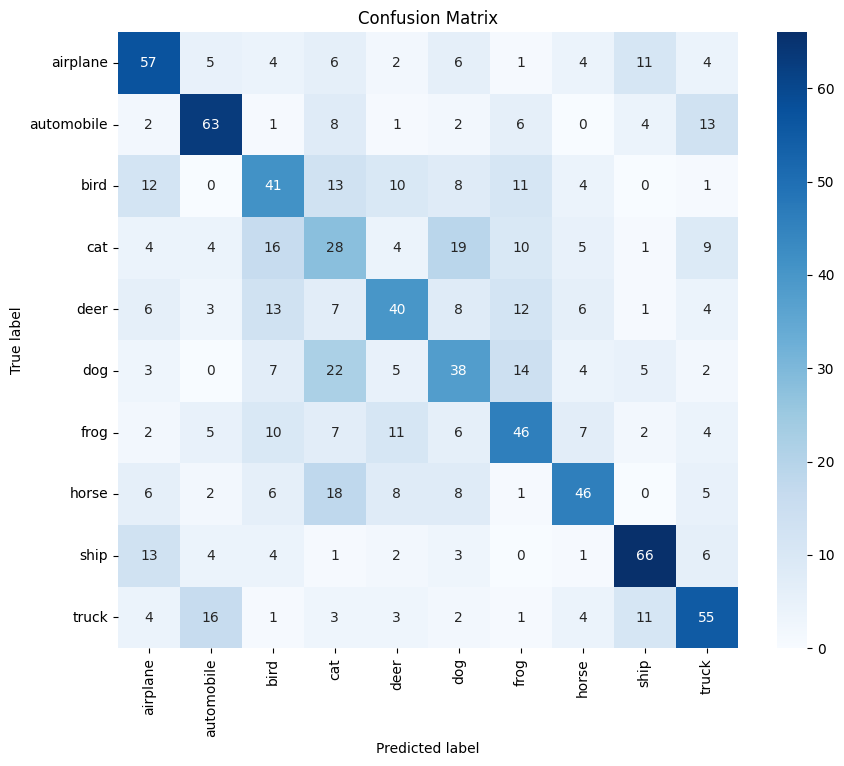

In [22]:
# Stampo la matrice di confusione usando seaborn
cm = confusion_matrix(y_test, y_pred_test)
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

